# asdnetv7 TPU
This notebook is part of ongoing research to develop computer vision solutions for diagnosing Autism Spectrum Disorder by way of functional magnetic resonance images (fMRIs).

----

This particular notebook is setup for use in Google Colab with a tensor processing unit (TPU).  Follow these steps to run the notebook:  
1. In Colab, ensure your instance is configured to use a TPU.  
2. Upload your GCS service account credential JSON file to the instance. 
3. Upload the colab_requirements.txt file in the config directory to the instance.  
4. Upload the asdnet_tools.zip file (compressed version of the directory) to the instance.  
5. Ensure the "colab" variable and the "first_run" variables are set to True.  
6. Run the first 2 cells in the notebook.  
7. Restart the instance runtime after the installations finish.  
8. Set the "first_run" variable to False. 
<br>  
**Everything is ready to go now!**

# colab instance setup

In [1]:
##############
colab = True   
first_run = False   
##############

In [2]:
if colab & first_run:
    !unzip -q ./asdnet_tools.zip 
    !pip3 install -r /content/colab_requirements.txt --upgrade  

# import

In [25]:
# requirements #
import pandas as pd 
import numpy as np 
import tensorflow as tf
from tensorflow import keras 
from sklearn.model_selection import train_test_split
import random 
import datetime 
####
from collections import OrderedDict, Counter 
import os 
pj = os.path.join
import pickle 
from pprint import pprint
import gc 
####
from asdnet_tools import augmentation, visualization, data_handler, modeler

# gcp storage setup
The data_handler class negotiates data transfers such as pulling data from GCS buckets, saving model weights to GCS buckets, fetching Tensorflow Datasets for training, etc.  See the data_handler script for details.

In [5]:
if colab:
    service_acct_fpath = '/content/asd-cv-prediction-service-acct-1-key.json'
else:
    service_acct_fpath = '../config/asd-cv-prediction-service-acct-1-key.json'
# instantiate the DataHandler object with a credential file and a GCS bucket name
dh = data_handler.DataHandler(service_acct_fpath, 'by_site')

# viz

In [6]:
# instantiate a Viz object for vizualizing results
viz = visualization.Viz(results_path='../results')

# data arrays

In [11]:
# fetch the pickled data and labels from the GCS bucket
# limiting the data to specific lists can be done with a list of sites
X, y = dh.get_pickled_data_arrays(site_ls=None, max_results=None)
print('DATA:\n', X.shape, '\n', y.shape, '\n', sep='')

DATA:
(884, 61, 73, 61, 1)
(884,)



In [12]:
# split the data into a train and validation set for experimentation
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=.2, shuffle=True, stratify=y)
print('TRAIN:\n', x_train.shape, '\n', y_train.shape, '\n', sep='')
print('VAL:\n', x_val.shape, '\n', y_val.shape, sep='')

TRAIN:
(707, 61, 73, 61, 1)
(707,)

VAL:
(177, 61, 73, 61, 1)
(177,)


In [13]:
# check class balances.  Because of the limited data available, forgoing balancing
Counter(y_train), Counter(y_val)

(Counter({0: 326, 1: 381}), Counter({0: 82, 1: 95}))

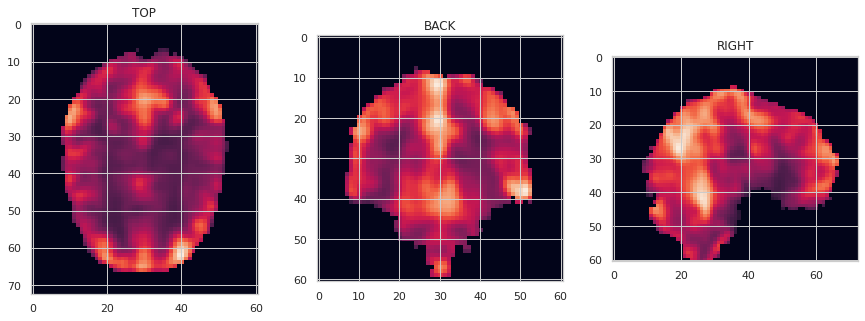

In [14]:
# visualize a data sample 
viz.show_slice(x_train[1])

train_preprocessing...
noise


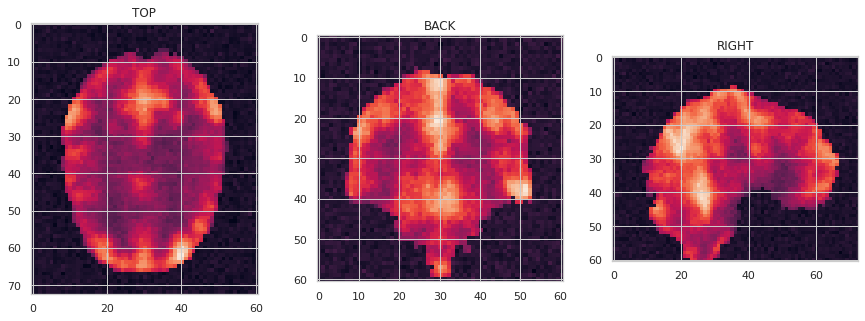

In [15]:
# instantiate a data Augmentor object
augmentor = augmentation.Augmentor([0, 0, 0, 0, 1])
# visualize a sample of augmented data
viz.show_slice(augmentor.train_preprocessing(x_train[1], 1)[0].numpy())

# params
These are the hyperparameters for modeling as well as the parameters for augmentation

In [16]:
#################
model_id = 2000
#################
batch_size = 64
#####################################################
#            [None, rotate, rotate90, warp, noise]
augweights = [1,      0,       0,      2,     2]
#####################################################

params = OrderedDict({
    'kreg': 1e-4,

    'b1do': .2,
    'b2do': .2,
    'b3do': .3,

    'b4do': .2,
    'b5do': .2,
    'b6do': .3,

    'b7do': .3,
    'b8do': .3,
    'b9do': .4,

    'b10do': .2,
    'b11do': .2,
    'b12do': .5,

    'topdrop1': .5,
    'topdrop2': .5
})

# reproducibility

In [17]:
tf.random.set_seed(92)
np.random.seed(92)
random.seed(92)

In [18]:
keras.backend.clear_session()
tf.get_logger().setLevel('ERROR')
_ = gc.collect() 

# tpu strategy

In [28]:
try:
    # Get a handle to the attached TPU. On GCP it will be the CloudTPU itself
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    print("Device:", tpu.master())
    # connect to the tpu cluster resolver
    tf.config.experimental_connect_to_cluster(tpu)
    # initialize the tpu system
    tf.tpu.experimental.initialize_tpu_system(tpu)
    # define a distribution strategy with the tpu cluster resolver
    strategy = tf.distribute.TPUStrategy(tpu)
    print('STATEGY: TPU CLUSTER', "Number of replicas:", strategy.num_replicas_in_sync)
except:
    print('problems with the TPU connection...')

######################      MODEL CREATION      #################################
with strategy.scope():
    # use the modeler script to define a model with the tpu strategy 
    m = modeler.create_model_skip_attention(
        model_id=model_id,
        params=params,
        compile=True, 
        batch_size=batch_size, 
        summary=False
        ) 
# model_id += 1
##############

Device: grpc://10.92.123.74:8470
STATEGY: TPU CLUSTER Number of replicas: 8
model compiled!
model created!


# data augmentor

In [29]:
# data augmentor instantiation 
augmentor = augmentation.Augmentor(augweights)

# datasets

In [30]:
# get train Dataset #
train_dataset = dh.get_dataset(
    x_train, y_train, batch_size, augmentor.train_preprocessing, train=True
)
# get val Dataset #
val_dataset = dh.get_dataset(x_val, y_val, batch_size)

train_preprocessing...
warp


# callbacks

In [31]:
reduce_lr_cb = keras.callbacks.ReduceLROnPlateau(
    monitor='loss', verbose=1, patience=20, mode='min', 
    cooldown=1, min_lr=1e-8
)
earlystop_cb = keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=.001, patience=60, verbose=1, restore_best_weights=True,
)

callbacks = [reduce_lr_cb, earlystop_cb]

# fit

In [32]:
# save initial weights #
dh.save_model_gcp(m, 'asdnetv4_results', init=True)

True

In [33]:
start = datetime.datetime.now() 
# fit model #
h = m.fit(
    x=train_dataset, 
    steps_per_epoch=(x_train.shape[0] * sum(augweights) // batch_size + 1), 
    validation_data=val_dataset,
    validation_steps=(x_val.shape[0] // batch_size + 1),
    epochs=200, 
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1
)
print('TOTAL EXEC TIME: ', round((datetime.datetime.now() - start).seconds / 60), ' mins')
# save trained model & weights #
# dh.save_model_gcp(m, 'asdnetv4_results', init=False)

Epoch 1/200
56/56 [==============================] - 42s 751ms/step - loss: 1.2148 - accuracy: 0.5134 - val_loss: 3.2344 - val_accuracy: 0.4948
Epoch 2/200
56/56 [==============================] - 25s 438ms/step - loss: 1.0499 - accuracy: 0.5075 - val_loss: 0.9624 - val_accuracy: 0.4896
Epoch 3/200
56/56 [==============================] - 25s 441ms/step - loss: 0.9828 - accuracy: 0.5131 - val_loss: 0.9356 - val_accuracy: 0.4948
Epoch 4/200
56/56 [==============================] - 25s 444ms/step - loss: 0.9671 - accuracy: 0.5140 - val_loss: 0.9310 - val_accuracy: 0.4948
Epoch 5/200
56/56 [==============================] - 25s 439ms/step - loss: 0.9592 - accuracy: 0.5232 - val_loss: 0.9281 - val_accuracy: 0.4948
Epoch 6/200
56/56 [==============================] - 25s 442ms/step - loss: 0.9541 - accuracy: 0.5243 - val_loss: 0.9239 - val_accuracy: 0.4948
Epoch 7/200
56/56 [==============================] - 25s 444ms/step - loss: 0.9495 - accuracy: 0.5240 - val_loss: 0.9188 - val_accuracy:

# visualize


OrderedDict([('kreg', 0.0001),
             ('b1do', 0.2),
             ('b2do', 0.2),
             ('b3do', 0.3),
             ('b4do', 0.2),
             ('b5do', 0.2),
             ('b6do', 0.3),
             ('b7do', 0.3),
             ('b8do', 0.3),
             ('b9do', 0.4),
             ('b10do', 0.2),
             ('b11do', 0.2),
             ('b12do', 0.5),
             ('topdrop1', 0.5),
             ('topdrop2', 0.5)])
[1, 0, 0, 2, 2]


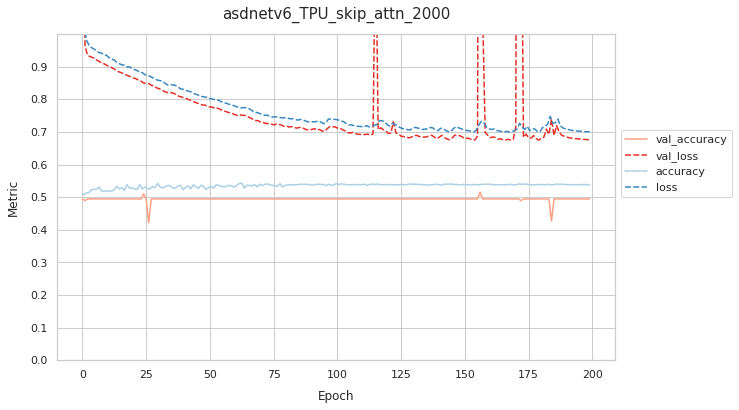

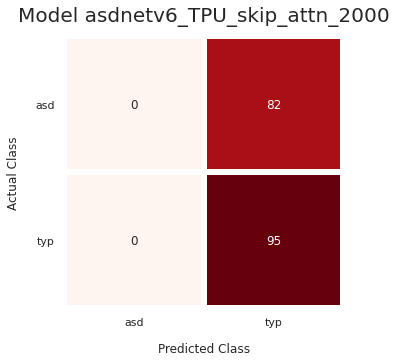

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


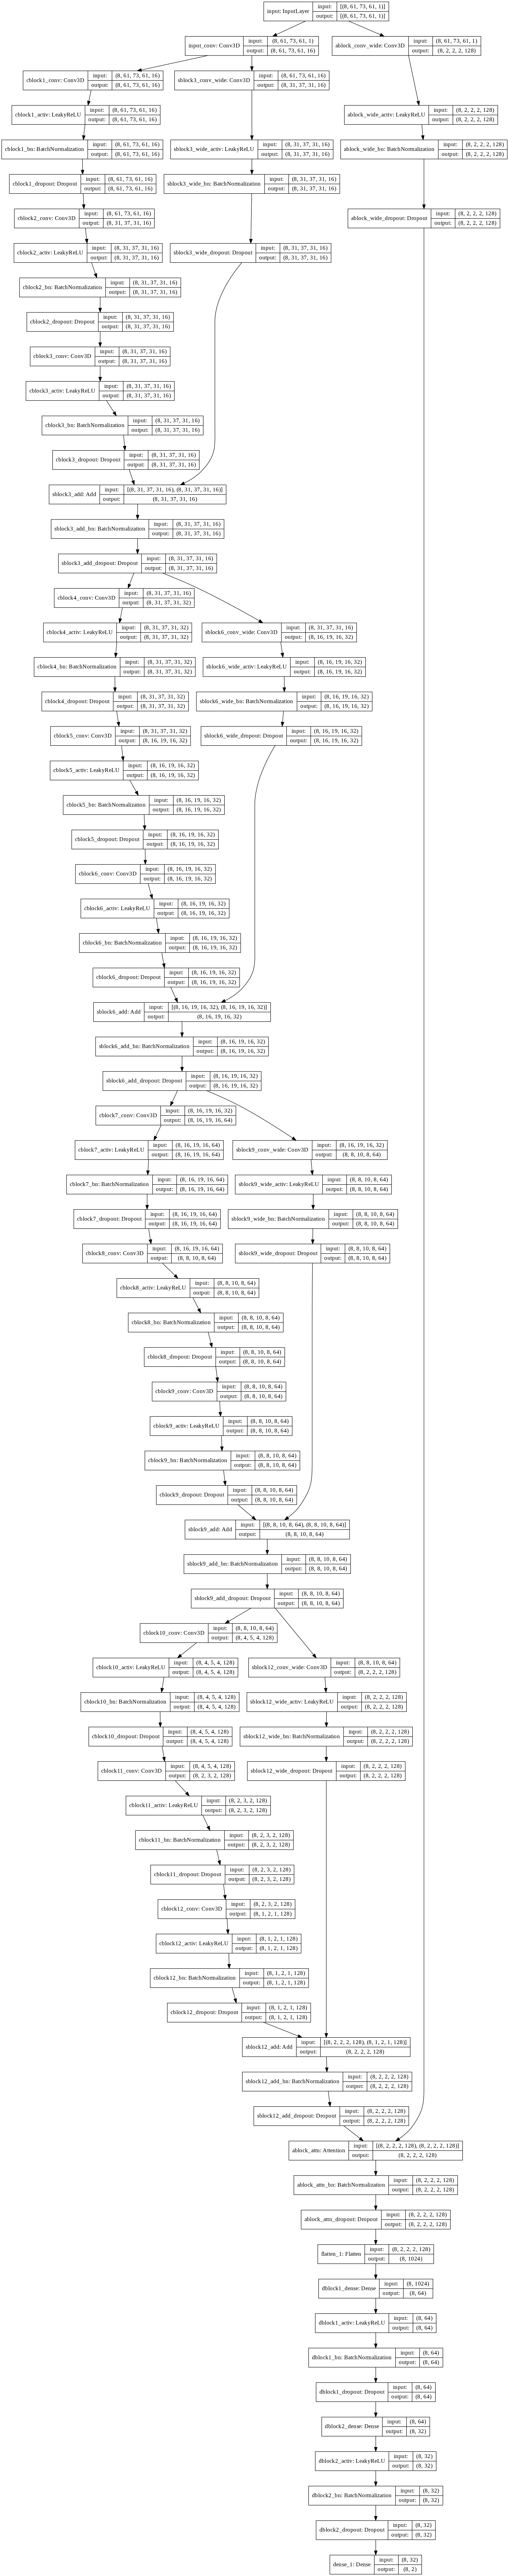

In [34]:
class_ls=['asd', 'typ']
# visualize the training metrics
viz.plot_metrics(h.history, m.name)
# plot the confusion matrix with the validation data
viz.plot_confusion_matrix(m, x_val, y_val, class_ls)
# fetch the classification report with the validation data
viz.get_classification_report(m, x_val, y_val, class_ls)
# plot the model structure
viz.plot_model_structure(m)

# clean tpu system

In [35]:
# shutdown tpu devices and clear all caches
tf.tpu.experimental.shutdown_tpu_system(cluster_resolver=None)